In [1]:
#HOW TO USE

#Data MUST be formatted with the first column titled "Wavelength", and every other column titled "mV_[VOLTAGE]"

#this can be done quickly by making a new row at the top of the sheet in Excel and pasting "=CONCATENATE("mV_", B2)" into the cell above the first wavelength
#then drag that cell across the row

#Only ONE Wavelength column, with Wavelength at the top of the column

#DELETE all text at the bottom of the file

#file MUST  be a CSV

#I've attached an example of correct format along with this file

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline
import pandas as pd
from matplotlib import cm

In [25]:
#normalizes a vector between 0 and 1
def normalize(vector):
    tmp_vector=vector-vector.min()
    normvector = tmp_vector / tmp_vector.max()
    return normvector



    
#finds a peak row within bounds
def peakseeker(df, lobound, hibound):
    upset=df.loc[df['Wavelength']>lobound] #takes the section of the df that's above the low bound
    subset=upset.loc[upset['Wavelength']<hibound] #takes the subsection of that df that's below the high bound
    subset=subset.reset_index(drop=True) #makes Wavelength no longer the index
    subset=subset.drop(['Wavelength'], axis=1) #removes Wavelength
    subset['mean'] = subset.mean(axis=1) #takes the mean of all rows in subset
    peak=subset.sort_values('mean').tail(1) #sorts them all by mean and takes the highest
    return peak

#converts the peak row into two columns, voltage and absorbance
def reframe(df):
    df=df.drop(['mean'], axis=1) #removes the mean column
    df = df.columns.to_frame().T.append(df, ignore_index=True) #these two lines convert the titles (the mVs) into a new row
    df.columns = range(len(df.columns)) 
    df=df.transpose() #turns the two rows into two columns
    c=0 # a counter
    for i in df[0]:
        df[0][c]=i.replace('mV_','') #gets rid of the mV_ tag on the milivoltages
        df[0][c]=float(df[0][c]) #turns the numbers into floats
        c=c+1
    return df




#fits a nernst curve to some data, with mV as the first column and absorbance as the second
def nernst(df, guess, potential):
    guess=[guess]
    mV=df[0].astype('float') #these lines are needed to recognize the whole columns as floats
    absor=df[1].astype('float')
    absor=normalize(absor)
    if potential==1:
        popt, pcov=curve_fit(onepot,mV,absor,guess) #optimizes to fit one potential nernst curve
        linEh = np.linspace(min(mV), max(mV), 100)
        plt.plot(linEh, onepot(linEh,*popt), label='fitted', color='red')
        residuals = absor- onepot(mV, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((absor-np.mean(absor))**2)
        r_squared = 1 - (ss_res / ss_tot)
    
    elif potential==2:
        popt, pcov=curve_fit(twopot,mV,absor,guess) #the two values of guess MUST be in parens
        linEh = np.linspace(min(mV), max(mV), 100)
        plt.plot(linEh, twopot(linEh,*popt), label='fitted', color='red')
        residuals = absor- twopot(mV, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((absor-np.mean(absor))**2)
        r_squared = 1 - (ss_res / ss_tot)
    plt.scatter(mV,absor,label='raw')
    plt.suptitle('Fitted Nernst')
    plt.xlabel('mV')
    plt.ylabel('Absorbance')
    plt.legend()
    #plt.savefig('FittedNernst.pdf', dpi=1000) #saves an image of your Nernst curve to your computer.  Uncomment this line and rename the file if you want a sharper image.
    plt.show() #displays the plot
    print("R^2=", r_squared)
    return popt,pcov #returns the predicted Em

In [26]:
#TEMPERATURES
#set temperature here!

#one potential nernst equation    
def onepot(Eh, Em):
    return (1/(10**((Eh-Em)/(8.314*295.15/(1*96.485)))+1))

#two potential nernst equation 
def twopot(Eh, Em1, Em2):
    return 0.5/(10**((Eh-Em1)/(8.314*295.15/(1*96.485)))+1)+0.5/(10**((Eh-Em2)/(8.314*295.15/(1*96.485)))+1)

#one potential negative nernst equation
def onepotnegative(Eh, Em):
    return (1/(10**((Eh-Em)/(8.314*295.15/(-1*96.485)))+1))

#two potential negative nernst equation
def twopotnegative(Eh, Em1, Em2):
    return 0.5/(10**((Eh-Em1)/(8.314*295.15/(-1*96.485)))+1)+0.5/(10**((Eh-Em2)/(8.314*295.15/(-1*96.485)))+1)


In [27]:
csv_file='E8Astar050609.csv' #replace with name of csv you are using
df = pd.read_csv(csv_file)
df.set_index('Wavelength')
peakrow=peakseeker(df, 540,580)
peakrow

,mV_247,mV_190,mV_172,mV_150,mV_136,mV_124,mV_114,mV_104,mV_95,mV_72,...,mV_-308,mV_-308.1,mV_-320,mV_-325,mV_-331,mV_-341,mV_-359,mV_-406,mV_-436,mean
19,0.459367,0.461999,0.466594,0.471091,0.473802,0.475478,0.477245,0.475426,0.473676,0.468526,...,0.813877,0.8077,0.893373,0.938224,0.969301,1.040431,1.130024,1.266279,1.262089,0.577909


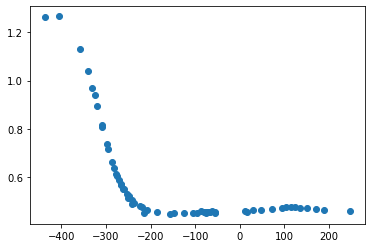

In [28]:
nedf=reframe(peakrow)
plt.scatter(nedf[0],nedf[1])

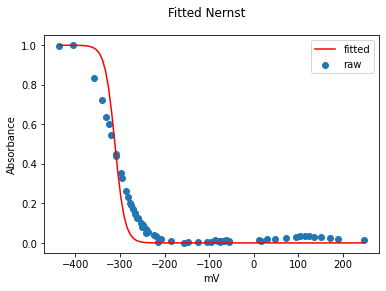

R^2= 0.8807184631750606
[-311.43075122]
+/- [1.81067939]


In [29]:
em,er=nernst(nedf,-200, 1)
print(em)
err = np.sqrt(np.diag(er))
print("+/-", err)

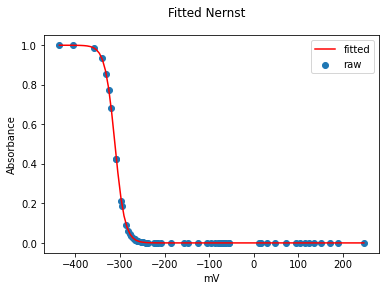

R^2= 0.9999999998701913


In [30]:
#for fraction reduced
FR=1/((10**((nedf[0]-em[0])/(8.314*295.15/(96.485)))+1))
e2,er=nernst((nedf[0],FR),-200, 1)

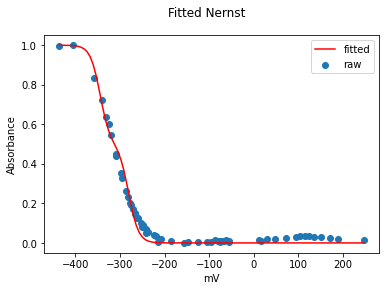

R^2= 0.9838510543516399
[-280.61231379 -344.54558572]
+/- [1.07580491 1.8825763 ]


In [31]:
ems,er=nernst(nedf,(-100,-300), 2) #the two values of "guess" must be in parens
print(ems)
err = np.sqrt(np.diag(er))
print("+/-", err)

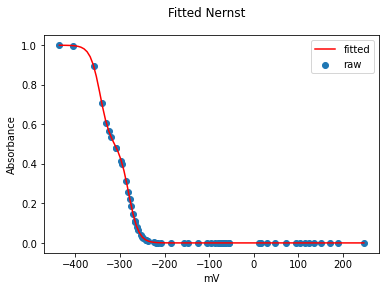

R^2= 0.999999990642504


In [32]:
#fraction reduced
FR=0.5/(10**((nedf[0]-ems[0])/(8.314*295.15/(96.485)))+1)+0.5/(10**((nedf[0]-ems[1])/(8.314*295.15/(96.485)))+1)
e2,er=nernst((nedf[0],FR),(-150,-200), 2)

(0.0, 1.5)

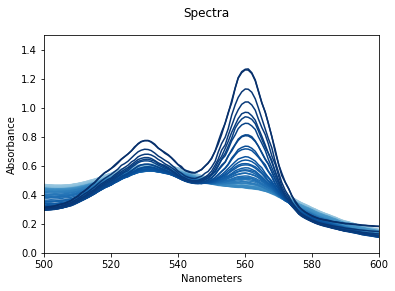

In [35]:
#this can gum up the first time you run it, run it again if it outputs something squirrely or has an error
columns = df.columns
y = df.columns[1: ]
color=iter(cm.Blues(np.linspace(0.3,1,len(y))))
for col in y:
    c=next(color)
    plt.plot(df['Wavelength'], df[col], color=c)

plt.xlabel('Nanometers')
plt.ylabel('Absorbance')
#plt.legend(y, loc='upper left')
plt.xlim(500,600)
plt.suptitle('Spectra')
plt.ylim(0,1.5)